In [1]:
import acquire
import prepare
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from math import sqrt

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression, RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

# Acquiring and Preparing zillow data
    

In [2]:
df = acquire.get_zillow_data()

Using cached csv


In [3]:
#checking shape to make sure I have the appropriate amount 
df.shape

(52441, 7)

In [4]:
# checking for null amounts
df.isnull().sum()

bedroomcnt                        0
bathroomcnt                       0
calculatedfinishedsquarefeet     82
lotsizesquarefeet               369
taxvaluedollarcnt                 1
yearbuilt                       116
fips                              0
dtype: int64

In [5]:
# Looking at data types

df.dtypes

bedroomcnt                      float64
bathroomcnt                     float64
calculatedfinishedsquarefeet    float64
lotsizesquarefeet               float64
taxvaluedollarcnt               float64
yearbuilt                       float64
fips                            float64
dtype: object

In [6]:
#general overview of the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,52441.0,3.300681,0.949094,0.0,3.0,3.0,4.00,14.0
bathroomcnt,52441.0,2.299403,1.022772,0.0,2.0,2.0,3.00,18.0
calculatedfinishedsquarefeet,52359.0,1922.890754,1004.365838,128.0,1268.0,1659.0,2306.00,21929.0
lotsizesquarefeet,52072.0,11339.624078,86747.634061,236.0,5583.0,6840.5,8798.25,6971010.0
taxvaluedollarcnt,52440.0,529688.163921,751894.553363,1000.0,193747.5,373612.0,619301.25,49061236.0
yearbuilt,52325.0,1963.393884,23.133571,1878.0,1950.0,1961.0,1979.00,2016.0
fips,52441.0,6049.132149,21.029067,6037.0,6037.0,6037.0,6059.00,6111.0


## Takeaway
    - 52k rows
    - tax values range from 1_000 to 49_061_236
    - average tax value is 529_688
    - min numbers like 0 and max numbers like 14/18 bedroom/bathroom 
    - other outliers within columns
    - messy columns names
    - missing values

In [7]:
# drop all null values from df 
df = df.dropna()

In [8]:
# clean all values and replace any missing

df= df.replace(r'^\s*$', np.nan, regex = True)

In [9]:
# check how many rows were lost when dropping null values
df.shape

(51959, 7)

In [10]:
# user friendly column names

df = df.rename( columns = {'bedroomcnt': 'bedroom',
                           'bathroomcnt': 'bathroom',
                           'calculatedfinishedsquarefeet':'square_ft',
                           'lotsizesquarefeet': 'lot_size',
                           'taxvaluedollarcnt': 'tax_value',
                           'yearbuilt': 'year_built'
                          })

In [11]:
df.columns.tolist()

['bedroom',
 'bathroom',
 'square_ft',
 'lot_size',
 'tax_value',
 'year_built',
 'fips']

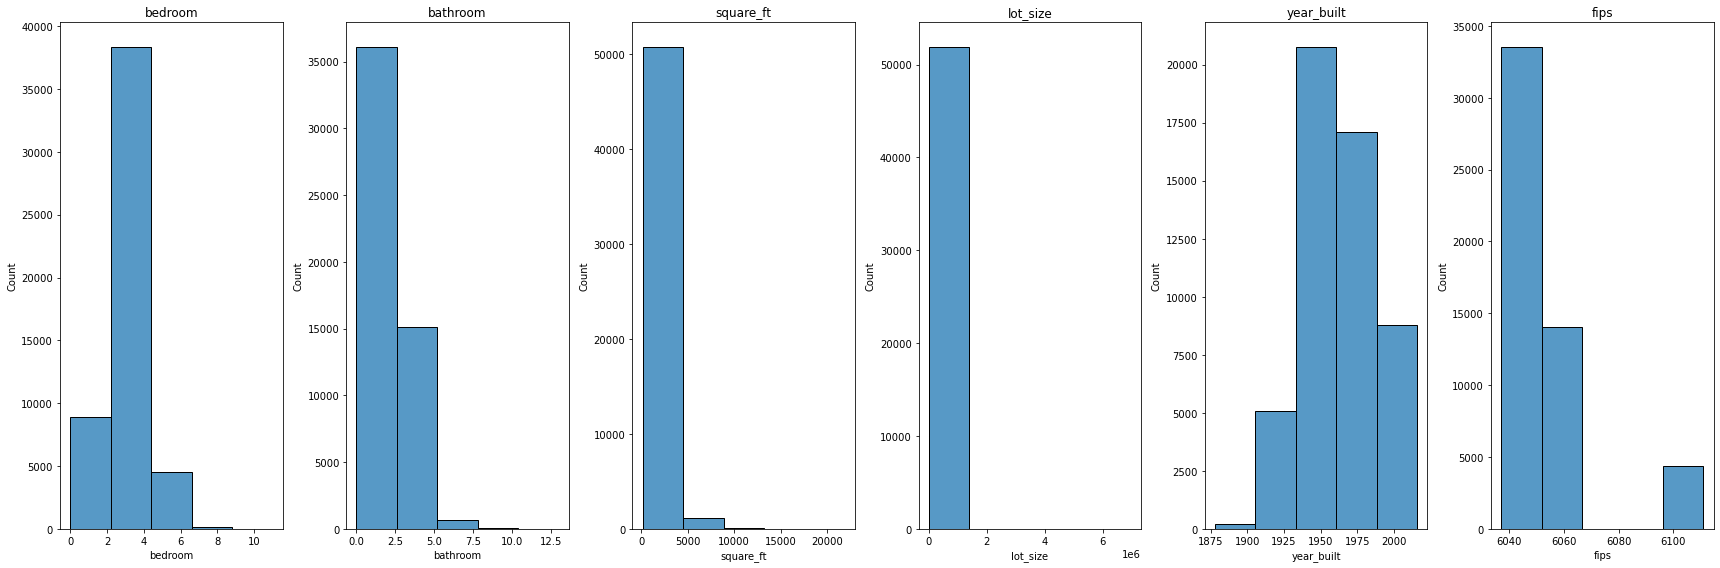

In [12]:
# Visualize Histograms

# list of numeric columns for histograms
cols = [col for col in df.columns if col not in ['tax_value']]

# figsize width to height
plt.figure(figsize=(24, 8))

# loop to iterate over columns
for i, col in enumerate(cols):
        
        # i starts at 0 but plot numbers should start at 1
        plot_number = i + 1
        
        # create subplot
        plt.subplot(1, len(cols), plot_number)
        
        # create title with the column name
        plt.title(col)
        
        # display a histogram for each of the columns            
        sns.histplot(df[col], bins=5)
        
        # Hide gridlines.
        plt.grid(False)
         
        # turn off scientific notation
        plt.ticklabel_format(useOffset=False)
    
plt.tight_layout()
plt.show()

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/an

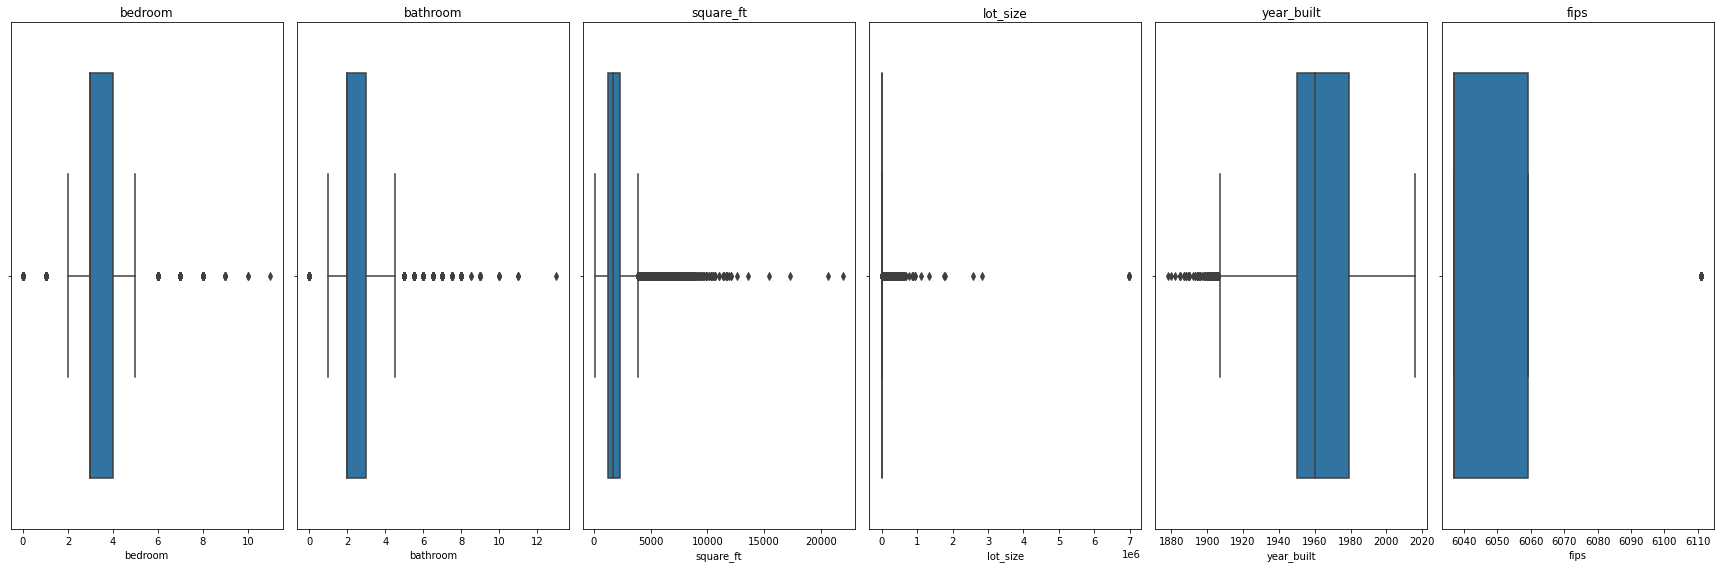

In [13]:
# Visualize Boxplots


# list of numeric columns
cols = [col for col in df.columns if col not in ['tax_value']]

# figsize width to height
plt.figure(figsize=(24, 8))

# loop to iterate over columns
for i, col in enumerate(cols):
        
        # i starts at 0 but plot numbers should start at 1
        plot_number = i + 1
        
        # create subplot
        plt.subplot(1, len(cols), plot_number)
        
        # create title with the column name
        plt.title(col)
        
        # display a boxplot for each of the columns            
        sns.boxplot(df[col])
        
        # Hide gridlines.
        plt.grid(False)
         
      
    
plt.tight_layout()
plt.show()

## Takeaway
    - scaling needed, histogram and boxplot not useful
    - data cannot give meaningful visualizations because of outliers
    - fips might work better with different dtypes 

In [14]:
# create an age column
df['age'] = 2017 - df.year_built
df.head(3)

,bedroom,bathroom,square_ft,lot_size,tax_value,year_built,fips,age
0,4.0,3.5,3100.0,4506.0,1023282.0,1998.0,6059.0,19.0
1,2.0,1.0,1465.0,12647.0,464000.0,1967.0,6111.0,50.0
2,3.0,2.0,1243.0,8432.0,564778.0,1962.0,6059.0,55.0


In [15]:
df['state'] = 'california'

In [16]:
df.dtypes

bedroom       float64
bathroom      float64
square_ft     float64
lot_size      float64
tax_value     float64
year_built    float64
fips          float64
age           float64
state          object
dtype: object

In [17]:
# Create list of datatypes I want to change
int_col_list = ['bedroom', 'bathroom', 'square_ft', 'lot_size', 'year_built','tax_value', 'age']
obj_col_list = ['fips']
    
# Change data types where it makes sense
for col in df:
    if col in int_col_list:
        df[col] = df[col].astype(int)
    if col in obj_col_list:
        df[col] = df[col].astype(int).astype(object)

In [18]:
# check the values

df.fips.value_counts()

6037    33567
6059    14034
6111     4358
Name: fips, dtype: int64

In [19]:
# replacing county values with more descriptive values

df.fips = df.fips.replace({6037: 'los_angeles', 6059: 'orange', 6111: 'ventura'})

In [20]:
df.fips.value_counts()

los_angeles    33567
orange         14034
ventura         4358
Name: fips, dtype: int64

In [21]:
# recheck the types

df.dtypes

bedroom        int64
bathroom       int64
square_ft      int64
lot_size       int64
tax_value      int64
year_built     int64
fips          object
age            int64
state         object
dtype: object

In [22]:
df.head()

,bedroom,bathroom,square_ft,lot_size,tax_value,year_built,fips,age,state
0,4,3,3100,4506,1023282,1998,orange,19,california
1,2,1,1465,12647,464000,1967,ventura,50,california
2,3,2,1243,8432,564778,1962,orange,55,california
3,4,3,2376,13038,145143,1970,los_angeles,47,california
4,4,3,2962,63000,773303,1950,los_angeles,67,california


In [23]:
#check dtypes and make adjustments in my wrangle.py notebook
df.dtypes

bedroom        int64
bathroom       int64
square_ft      int64
lot_size       int64
tax_value      int64
year_built     int64
fips          object
age            int64
state         object
dtype: object

In [24]:
# creat dummy columns for fips so it will be easier to evaluate later

dummy_df = pd.get_dummies(df['fips'])
df = pd.concat([df, dummy_df], axis = 1)

In [25]:
# look at df witih dummy columns added
df.head()

,bedroom,bathroom,square_ft,lot_size,tax_value,year_built,fips,age,state,los_angeles,orange,ventura
0,4,3,3100,4506,1023282,1998,orange,19,california,0,1,0
1,2,1,1465,12647,464000,1967,ventura,50,california,0,0,1
2,3,2,1243,8432,564778,1962,orange,55,california,0,1,0
3,4,3,2376,13038,145143,1970,los_angeles,47,california,1,0,0
4,4,3,2962,63000,773303,1950,los_angeles,67,california,1,0,0


In [26]:
# general overview after some changes have been made

df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroom,51959.0,3.304952,0.934239,0.0,3.0,3.0,4.0,11.0
bathroom,51959.0,2.233222,0.989084,0.0,2.0,2.0,3.0,13.0
square_ft,51959.0,1918.251506,994.308287,128.0,1268.0,1657.0,2301.0,21929.0
lot_size,51959.0,11251.588830,86640.635731,236.0,5581.5,6838.0,8777.0,6971010.0
tax_value,51959.0,525552.311842,716442.460110,1000.0,193482.5,372791.0,616741.5,25381250.0
year_built,51959.0,1963.247849,22.976170,1878.0,1950.0,1960.0,1979.0,2016.0
age,51959.0,53.752151,22.976170,1.0,38.0,57.0,67.0,139.0
los_angeles,51959.0,0.646029,0.478205,0.0,0.0,1.0,1.0,1.0
orange,51959.0,0.270098,0.444014,0.0,0.0,0.0,1.0,1.0
ventura,51959.0,0.083874,0.277201,0.0,0.0,0.0,0.0,1.0


In [27]:
# addressing the outliers in the dataset

def remove_outliers(df, k, col_list):
    ''' this function take in a dataframe, k value, and specified columns 
    within a dataframe and then return the dataframe with outliers removed
    '''
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [28]:
df = remove_outliers(df, 3.0, ['bedroom', 'bathroom', 'square_ft','lot_size', 'tax_value', 'age', 'year_built'])

In [29]:
# re-checking my dataframe and seeing outliers removed

df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroom,46857.0,3.241650,0.869577,1.0,3.0,3.0,4.0,6.0
bathroom,46857.0,2.103997,0.808444,0.0,2.0,2.0,3.0,5.0
square_ft,46857.0,1764.695883,723.879816,152.0,1242.0,1593.0,2130.0,5288.0
lot_size,46857.0,7013.844826,2735.086760,236.0,5450.0,6615.0,8003.0,17787.0
tax_value,46857.0,416710.415221,314126.220167,3254.0,183437.0,352080.0,559188.0,1751776.0
year_built,46857.0,1962.249952,22.576541,1878.0,1950.0,1959.0,1977.0,2016.0
age,46857.0,54.750048,22.576541,1.0,40.0,58.0,67.0,139.0
los_angeles,46857.0,0.640438,0.479877,0.0,0.0,1.0,1.0,1.0
orange,46857.0,0.277973,0.448005,0.0,0.0,0.0,1.0,1.0
ventura,46857.0,0.081589,0.273740,0.0,0.0,0.0,0.0,1.0


In [30]:
df.dtypes

bedroom         int64
bathroom        int64
square_ft       int64
lot_size        int64
tax_value       int64
year_built      int64
fips           object
age             int64
state          object
los_angeles     uint8
orange          uint8
ventura         uint8
dtype: object

In [31]:
# Check how many rows dropped after cleaning

df.shape

(46857, 12)

### Takeaways
- 46_857 rows left. 7K dropped
    - MEAN home value 416_710  
    - MAX  home value 1_751_776 
- null values dropped
- outliers removed
- columns renamed
- data types adjusted
- fips columns converted to 'county' column

# Exploration

In [32]:
train, validate, test,train_scaled, validate_scaled, test_scaled = prepare.wrangle_zillow()

Using cached csv


In [33]:
train.shape, validate.shape, test.shape

((26239, 12), (11246, 12), (9372, 12))

df2.describe().T

### Takeaways
- There were some outliers that made initial visualizations difficult. 
- Outliers needed to be removed.

## Exploration
    - What drives property tax values


In [34]:
train, validate, test = prepare.wrangle_zillow()

Using cached csv


ValueError: too many values to unpack (expected 3)

In [ ]:
train.shape, validate.shape, test.shape

In [ ]:
train.isnull().sum()

In [ ]:
train.dtypes

In [ ]:
train.describe().T

In [ ]:
train.head()

In [ ]:
# create a function that takes in a dataframe

continuous_cols = ['bedroom', 'bathroom', 'square_ft', 'lot_size', 'age']


def plot_variable_pairs(df):
    # plot the columns in a pairplot
    sns.pairplot(df, kind = 'reg', corner = True, plot_kws={'line_kws':{'color':'orange'}})
plt.show()

In [ ]:
# call function to visualize continuous columns in the train dataset
plot_variable_pairs(train[continuous_cols])

In [ ]:
# Heatmap to visualize correlations in data

df_corr = train.corr().reset_index()
corr_matrix = train.corr().sort_values(by = 'tax_value', ascending=False)
corr_matrix["tax_value"].reset_index().style.background_gradient('gist_earth', vmin = -1, vmax = 1)

## **Questions**
#### - Does county affect tax value?
#### - Does square footage have an affect on tax value?
#### - Does bedroom or bathroom count have an affect on tax value?
#### - Does the age of the house affect tax value?

### Question 1:
        - exploring county and tax_values

In [ ]:

plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.countplot(x='county', palette='cubehelix', data=train)
plt.title('Los Angeles has the Most Properties Sold', fontsize=15)

plt.subplot(1,2,2)
sns.boxplot(x='county', y='tax_value', data=train , palette='cubehelix')
plt.title('Tax Values are Highest in Orange County', fontsize=15)

plt.tight_layout()

In [ ]:
# look at ttest for orange county
# spearmanr for county

### Question 2 
        - exploring square_ft and tax_value

In [ ]:
# jointplot for 
plt.figure(figsize=(10,8))
sns.jointplot(x= 'square_ft',y= 'tax_value', data=train, kind = 'reg', line_kws = {'color' :'red'})
plt.show()

### Hypothesis testing with Pearson's r

    Null Hypothesis : There is no linear relationship between square_ft and property tax value

    Alternative Hypothesis: There is a linear relationship between square_ft and tax value

In [ ]:
alpha = .05
r, p_value = stats.pearsonr(train.square_ft, train.tax_value)
r, p_value

if p_value > alpha:
    print('We fail to reject the null hypothesis')
else:
    print('We reject the null hypothesis')
print(f'p-value: {round(p_value,3)}')

### Question 3:
        - explore bedroom and tax_value

In [ ]:
# Visualize number of bedrooms and their relationship with tax value

ax = sns.relplot(x='bedroom', y='tax_value', data=train, kind='scatter', hue='county')
ax.set(yscale='log')
plt.title('Bedroom and tax value')
plt.show()

### Hypothesis testing with Pearson's r

    Null Hypothesis : There is no linear relationship between number of bedrooms and property tax value

    Alternative Hypothesis: There is a linear relationship between number of bedrooms and tax value

In [ ]:
# statistical analysis to of visual above

alpha = 0.05

r, p_value = pearsonr(train.bedroom, train.tax_value)

if p_value > alpha:
    print('We fail to reject the null hypothesis')
else:
    print('We reject the null hypothesis')
print(f'p-value: {round(p_value,3)}')

### Question 4
        - Explore bathroom and tax_value

In [ ]:
#visualize bathroom and tax value

ax2 = sns.relplot(x='bathroom', y='tax_value', data=train, kind='scatter', hue='county')
ax2.set(yscale='log')
plt.title('Bathroom and tax value')
plt.show()

alpha = 0.05


### Hypothesis testing with Pearson's r

    Null Hypothesis : There is no linear relationship between number of bathrooms and property tax value

    Alternative Hypothesis: There is a linear relationship between number of bathrooms and tax value

In [ ]:
alpha = 0.05

r, p_value = pearsonr(train.bathroom, train.tax_value)

if p_value > alpha:
    print('We fail to reject the null hypothesis')
else:
    print('We reject the null hypothesis')
print(f'p-value: {round(p_value,3)}')

### Question 5:
    - Explore lot_size and tax_value

In [ ]:
# visualize lot_size and tax_value
sns.jointplot('lot_size', 'tax_value', data=train, kind = 'reg', line_kws={'color':'red'})
plt.show()


### Hypothesis testing with Pearson's r

    Null Hypothesis : There is no linear relationship between square_ft and property tax value

    Alternative Hypothesis: There is a linear relationship between square_ft and tax value

In [ ]:
# statistical analysis to of visual above

alpha = 0.05

r, p_value = pearsonr(train.bedroom, train.tax_value)

if p_value > alpha:
    print('We fail to reject the null hypothesis')
else:
    print('We reject the null hypothesis')
print(f'p-value: {round(p_value,3)}')

### Question 6:
    - Explore age and tax_value

In [ ]:
sns.jointplot(train.age, train.tax_value, kind = 'reg', line_kws = {'color': 'red'})
ax.set(
    xlabel='House Age',
    ylabel='Price / Area',
    title='Seems to be little to no relationship between house age and price',
)
plt.show()

# Modeling
    - Data needs to be scaled for modeling

In [ ]:
# columns need scaling

def scale_data(train, validate, test, return_scaler=False):
    '''
    Scales the 3 data splits.
    
    takes in the train, validate, and test data splits and returns their scaled counterparts.
    
    If return_scaler is true, the scaler object will be returned as well.
    '''
    columns_to_scale = ['bedroom', 'bathroom', 'square_ft', 'lot_size', 'age']
    
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    scaler = MinMaxScaler()
    scaler.fit(train[columns_to_scale])
    
    train_scaled[columns_to_scale] = scaler.transform(train[columns_to_scale])
    validate_scaled[columns_to_scale] = scaler.transform(validate[columns_to_scale])
    test_scaled[columns_to_scale] = scaler.transform(test[columns_to_scale])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [ ]:
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test)
train_scaled.shape, validate_scaled.shape, test_scaled.shape

In [ ]:
train_scaled.head()

In [ ]:
# set my X_train and y_train variables based on the scaled/not scaled data
X_train = train_scaled.drop(columns = ['tax_value', 'county','los_angeles', 'orange', 'ventura'])
y_train = pd.DataFrame(train.tax_value)

X_validate = validate_scaled.drop(columns = ['tax_value', 'county','los_angeles', 'orange', 'ventura'])
y_validate = pd.DataFrame(validate.tax_value)

X_test = test_scaled.drop(columns = ['tax_value', 'county','los_angeles', 'orange', 'ventura'])
y_test= pd.DataFrame(test.tax_value)

In [ ]:
y_train.head()

In [ ]:
plt.figure(figsize=(12,8))
sns.histplot(y_train.tax_value)
plt.show()

In [ ]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=3)

# fit the data using RFE
rfe.fit(X_train , y_train)  

feature_mask = rfe.support_

rfe_feature = X_train.iloc[:, feature_mask].columns.tolist()

rfe_feature

## **Baseline**

In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict tax value_pred_mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

# 2. compute tax value_pred_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# 3. RMSE of tax_value_pred_mean
mean_rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
mean_rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(mean_rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(mean_rmse_validate, 2))

# 4. RMSE of tax_value_pred_median
median_rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
median_rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("\nRMSE using Median\nTrain/In-Sample: ", round(median_rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(median_rmse_validate, 2))


### **Linear Regression (OLS)**

In [ ]:
X_train.head()

In [ ]:
# create the Linear Regression model object
lm = LinearRegression(normalize=True)

# fit the model to training data and specify column in y_train  
lm.fit(X_train[['bedroom', 'bathroom', 'square_ft']], y_train.tax_value)

# predict train & validate
y_train['tax_value_pred_lm'] = lm.predict(X_train[['bedroom', 'bathroom', 'square_ft']])
y_validate['tax_value_pred_lm'] = lm.predict(X_validate[['bedroom', 'bathroom', 'square_ft']])

# evaluate rmse for train & validate
lm_rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)
lm_rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\n\nTraining/In-Sample: ", lm_rmse_train, 
      "\nValidation/Out-of-Sample: ", lm_rmse_validate)

### **LassoLars**

In [ ]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train[['bedroom', 'bathroom', 'square_ft']], y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train[['bedroom', 'bathroom', 'square_ft']])

# evaluate: rmse
ll_rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate[['bedroom', 'bathroom', 'square_ft']])

# evaluate: rmse
ll_rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\n\nTraining/In-Sample: ", ll_rmse_train, 
      "\nValidation/Out-of-Sample: ", ll_rmse_validate)


### **TweedieRegressor (GLM)**

In [ ]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train[['bedroom', 'bathroom', 'square_ft']], y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train[['bedroom', 'bathroom', 'square_ft']])

# evaluate: rmse
glm_rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate[['bedroom', 'bathroom', 'square_ft']])

# evaluate: rmse
glm_rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\n\nTraining/In-Sample: ", glm_rmse_train, 
      "\nValidation/Out-of-Sample: ", glm_rmse_validate)

### **PolynomialFeatures**

In [ ]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train[['bedroom', 'bathroom', 'square_ft']])

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate[['bedroom', 'bathroom', 'square_ft']])
X_test_degree3 = pf.transform(X_test[['bedroom', 'bathroom', 'square_ft']])


In [ ]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree3)

# evaluate: rmse
pf_rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2)**(1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree3)

# evaluate: rmse
pf_rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=3\n\nTraining/In-Sample: ", pf_rmse_train, 
      "\nValidation/Out-of-Sample: ", pf_rmse_validate)


## **Evaluate**
#### **Plotting Actual vs. Predicted Values**

In [ ]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.tax_value_pred_mean, alpha=.5, color="black", label='Baseline: Predict Using Mean')
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="red", label='The Ideal Line: Predicted = Actual')


plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm, 
            alpha=.5, marker = '^', color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm, 
            alpha=.5, marker = '*', color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2, 
            alpha=.5, marker = '+', color="green", s=100, label="Model 3rd degree Polynomial")
plt.legend()
plt.xlabel("Actual Property Tax Value")
plt.ylabel("Predicted Property Tax Value")
plt.title("Where are predictions more extreme? More modest?")
plt.show()


In [ ]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm-y_validate.tax_value, 
            alpha=.5, marker = '^', color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm-y_validate.tax_value, 
            alpha=.5, marker = '*', color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2-y_validate.tax_value, 
            alpha=.5, marker = '+', color="green", s=100, label="Model 3rd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted value - Actual value")
plt.title("Do the size of errors change as the actual value changes?")
plt.show()


In [ ]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Predicted Value")
plt.hist(y_validate.tax_value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tax_value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.tax_value_pred_lm2, color='green', alpha=.5, label="Model 3rd degree Polynomial")
plt.xlabel("Tax Value")
plt.ylabel("Number of Properties")
plt.title("Comparing the Distribution of Actual Tax Values to Distributions of Predicted Tax Values for the Top Models")
plt.legend()
plt.show()


In [ ]:
metric_df = pd.DataFrame(data = [{'Model': 'Baseline', 'Train Baseline': mean_rmse_train, 'Validate Baseline':mean_rmse_validate, 
                          }])

In [ ]:
metric_df = metric_df.append({'Model': 'Linear Regression', 'Train Baseline': lm_rmse_train , 'Validate Baseline':lm_rmse_validate, 
                          }, ignore_index = True)
metric_df = metric_df.append({'Model': 'LassoLars', 'Train Baseline': ll_rmse_train , 'Validate Baseline':ll_rmse_validate, 
                          }, ignore_index = True)
metric_df = metric_df.append({'Model': 'TweedieRegressor (GLM)', 'Train Baseline': glm_rmse_train , 'Validate Baseline':glm_rmse_validate, 
                          }, ignore_index = True)
metric_df = metric_df.append({'Model': 'PolynomialFeatures', 'Train Baseline': pf_rmse_train , 'Validate Baseline':pf_rmse_validate, 
                          }, ignore_index = True)

In [ ]:
metric_df

In [ ]:
y_test = pd.DataFrame(y_test)

# Fit the data
lm2.fit(X_test_degree3, y_test.tax_value)

# predict on test
y_test['tax_value_pred_lm2'] = lm2.predict(X_test_degree3)
                                
# evaluate: rmse
pf_rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm2)**(1/2)

print("RMSE for Test Model using 3rd Degree Polynomial\n\nTest Performance: ", pf_rmse_test)


In [ ]:
y_test['lm2_resid'] = y_test.tax_value - y_test.tax_value_pred_lm2
y_test

In [ ]:
# visual of residuals 

def plot_residuals(actual, predicted):
    #plt.figure(figsize = (10,8))
    residuals = actual - predicted
    plt.hlines(0, actual.min(), actual.max(), ls=':', color ='red')
    sns.scatterplot(actual, residuals, marker = '+')
    plt.ylabel('residual ($y - \hat{y}$)')
    plt.xlabel('actual value ($y$)')
    plt.title('Actual vs Residual')
    plt.show()


In [ ]:
# calling function

plot_residuals(y_test.tax_value, y_test.tax_value_pred_lm2)

In [ ]:

ax=sns.residplot(x = "tax_value",
              y = "tax_value_pred_lm2",
              data = y_test, color = 'green')
ax.set( ylabel = "residual", xlabel = "Tax Value")